# PREDITING THE SURVIVAL OF PASSENGERS
-----

# VARIABLE DESCRIPTIONS

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix,precision_recall_curve
import os
from pandas.plotting import  scatter_matrix
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer as Imputer
import pandas_summary as pds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
np.random.seed(99999)
%matplotlib inline

In [2]:
# directory
!pwd

C:\Users\USER\Videos\MYGIT\machine-learning-with-python-master\notebook


In [3]:
def load_data(data=None,path=None):
    df=os.path.join(path,data)
    return pd.read_csv(df)

In [5]:
df=load_data(data='train.csv',path=r'data/titanic/')
df.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

# Data Exploration

In [155]:
# the data is made up of 891 observations each describe by 11 features and a target variable named (survived) describing 
# whether a passenger survived or not
df.shape

(891, 12)

In [156]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [157]:
# data type of each field
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [158]:
# converting these columns to catagorical variables
cat=['Survived','Pclass','Sex','Embarked']
for i in cat:
    df[i]=pd.Categorical(df[i]) 

In [159]:
df.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [160]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [161]:
# unigue category in sibsp
df.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [162]:
# SibSp ,Parch, are ordinal data type and has 7 classes ( which means can be ordder) this 
# code convert sibsp to ordinal categorical data type
df['SibSp']=pd.Categorical(df.SibSp,ordered=True,categories=[0,1, 2,3, 4,5, 8])

In [163]:
df.SibSp.unique()

[1, 0, 3, 4, 2, 5, 8]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 8]

In [164]:
df.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [165]:
df['Parch']=pd.Categorical(df.Parch,ordered=True,categories=[0, 1, 2,3,4, 5, 6])

In [166]:
df.Parch.unique()

[0, 1, 2, 5, 3, 4, 6]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [167]:
# converting the data type to float64
df[['PassengerId', 'Age', 'Fare']]=df[['PassengerId', 'Age', 'Fare']].astype('float64')

In [168]:
df.dtypes

PassengerId     float64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp          category
Parch          category
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

# Detecting and treating missing values

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null float64
Survived       891 non-null category
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float64
SibSp          891 non-null category
Parch          891 non-null category
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: category(6), float64(3), object(3)
memory usage: 48.2+ KB


the result above shows that embarked contains 2 missing values(891-889), 177 (891-714) for age and 687(891-204) for cabin

In [170]:
# the sum of missing values ( confirming the number of missing values)
print('columns----- ---sum of missing values \n \n',df.isnull().sum())


columns----- ---sum of missing values 
 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


 from the displayed result there are 177 ,687 and 2 missing values for AGE Cabin and embarked respectively 
 

In [171]:
# percentage of missing values within each field
print('columns----- ---percentage of missing values \n \n',((df.isnull().sum())/len(df))*100)


columns----- ---percentage of missing values 
 
 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


from the result cabin contains about 77.1% of missing values with Age and embarked containing 19.9 and .2 respectively 

since cabin contains about 77% (magority of it values are  missing) missing values it will be droped 

In [172]:
# droping cabin and ticket columns
# dropping PassengerId since it's an identifier and is no use to us 
df.drop(['Cabin','PassengerId','Ticket','Name'],axis=1,inplace=True)

In [173]:
df.head(3)

Survived Pclass     Sex   Age SibSp Parch     Fare Embarked
0        0      3    male  22.0     1     0   7.2500        S
1        1      1  female  38.0     1     0  71.2833        C
2        1      3  female  26.0     0     0   7.9250        S

In [174]:
#Port of Embarkation (C=Cherbourg,Q=Queenstown,S=Southampton)
# most of the passenger departed from S
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [175]:
df.Embarked.unique()

[S, C, Q, NaN]
Categories (3, object): [S, C, Q]

In [176]:
# since most people departed from S, it is most likely that the missing values for passengers under Port of Embarkation 
#departed from S=Southampton
df.Embarked.fillna('S',inplace=True)

In [177]:
df.Embarked.unique()

[S, C, Q]
Categories (3, object): [S, C, Q]

In [178]:
df.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [179]:
# replacing age missing values with it mean
df.Age.fillna(df.Age.mean(),inplace=True)

In [180]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

#  DATA VISUALIZATION

In [181]:
df.dtypes

Survived    category
Pclass      category
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
Embarked    category
dtype: object

In [182]:
df.SibSp.unique()

[1, 0, 3, 4, 2, 5, 8]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 8]

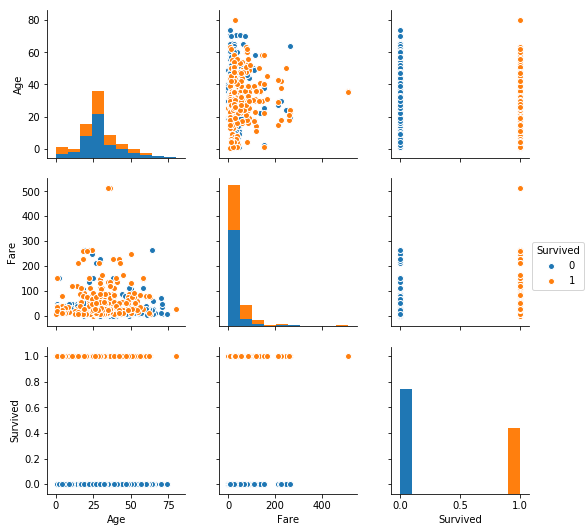

In [183]:
num=['Age', 'Fare','Survived']
sns.pairplot(df[num], hue='Survived', size=2.5);

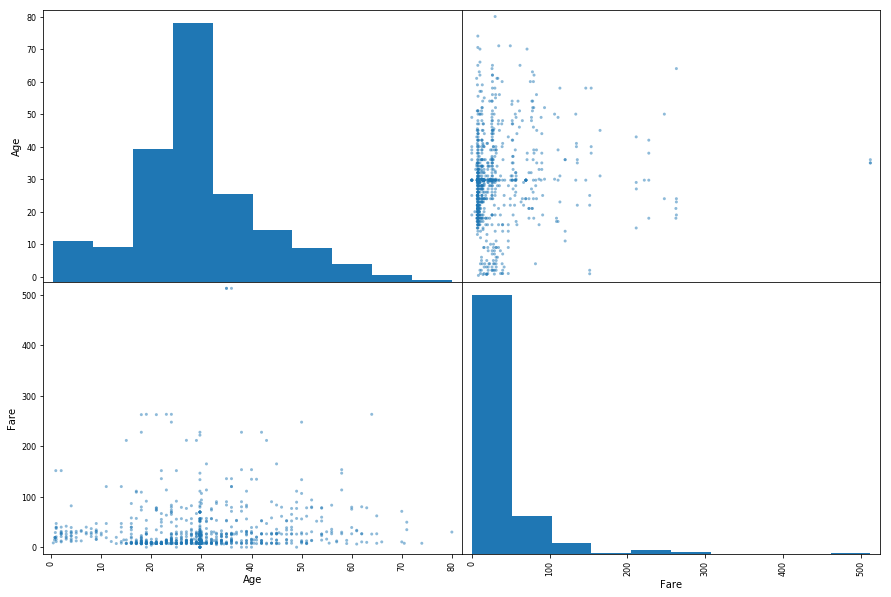

In [184]:
num=['Age', 'Fare']
scatter_matrix(df[num],figsize=(15,10))
plt.show()

there seems to be no relationship between age and fare

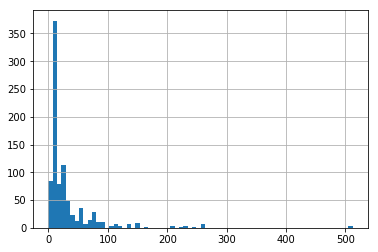

In [185]:
df.Fare.hist(bins=70)
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


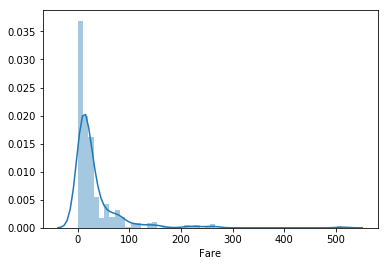

In [186]:
sns.distplot(df.Fare)
plt.show()

the distribution for fare is skewed to the right which seems to be an indication that most of the passengers who survived were passengers in the 1st class group ( ordered to be the lowest when converting pclass in rodinal data type)

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


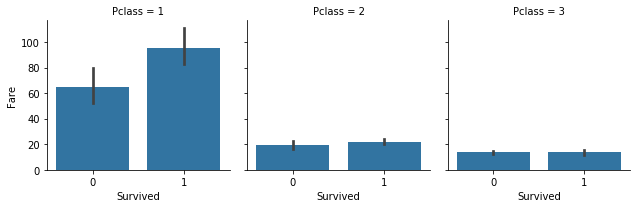

In [187]:
g=sns.FacetGrid(df,col='Pclass')
g.map(sns.barplot ,'Survived','Fare')
plt.show()

this results confirm our assumption that most survived passengers were first classed passengers

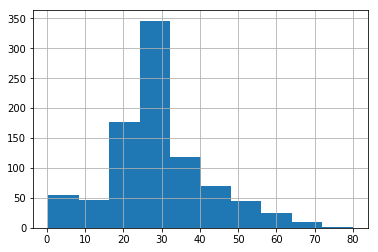

In [188]:
# the distribution of age seems to be normally distributed
df.Age.hist()
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


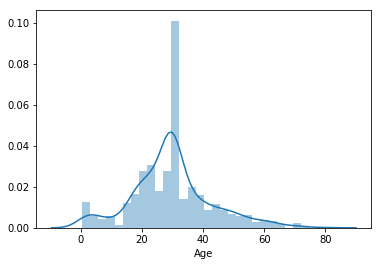

In [189]:
sns.distplot(df.Age)
plt.show()

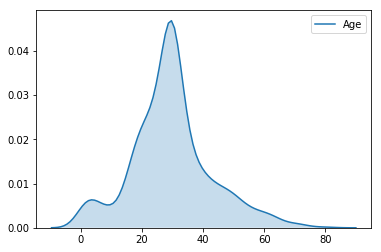

In [190]:
sns.kdeplot(df.Age,shade=True)
plt.show()

In [191]:
print('passengers who did not survived constitute {} of the total data set \n \n while {} is for survived passengers'
      .format(np.round((549 /len(df))*100,2),np.round((342 /len(df))*100,2)))

passengers who did not survived constitute 61.62 of the total data set 
 
 while 38.38 is for survived passengers


the data seems to be an unbalanced data set (we will deal with that later) since the perished class is almost 2 times that of the survived class

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


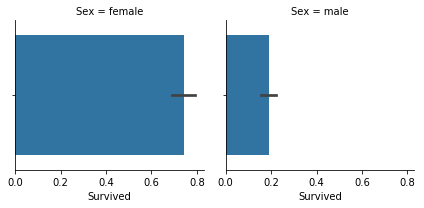

In [192]:
g=sns.FacetGrid(df,col='Sex')
g.map(sns.barplot ,'Survived')
plt.show()

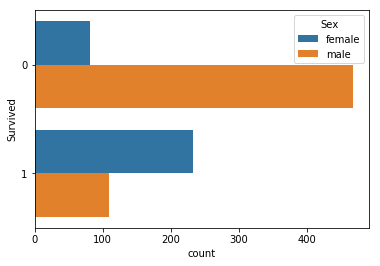

In [193]:
sns.countplot(hue='Sex',y='Survived',data=df)

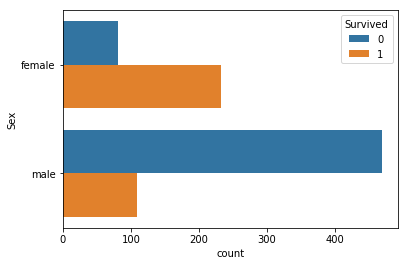

In [194]:
sns.countplot(y='Sex',hue='Survived',data=df)

# more females survived than their male counterpart

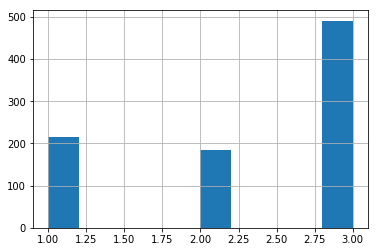

In [195]:
df.Pclass.hist()
plt.show()

most passengers were 3rd class passengers

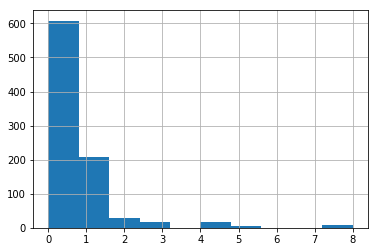

In [196]:
df.SibSp.hist()
plt.show()

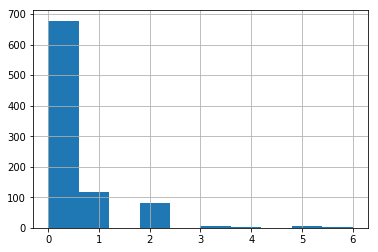

In [197]:
df.Parch.hist()
plt.show()

<Figure size 504x432 with 0 Axes>

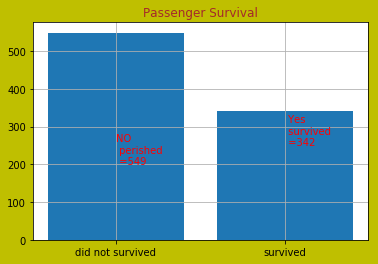

In [198]:
name=['did not survived','survived']
def plot_target_classes(names=None,data=None,colors='green'):
    plt.figure(figsize=(7,6))
    fig, ax = plt.subplots(facecolor='y')
 #   plt.figure(figsize=(5,4))
    ax.bar(names,data)
    ax.text(1,250,' Yes \n survived \n =342',color='red')
    ax.text(0,200,'NO \n perished \n =549',color='red')
    plt.title('Passenger Survival',color='brown')
    ax.grid(True)
    plt.show()
    
plot_target_classes(name,df.Survived.value_counts())

the data seems to be an un balanced date set with  38.38% ((342 / len(df)) *100)  representing the survived class and 
61.62 for the perished class.  building a model with this dataset will likely ignore the minority class( survived) in it's prediction

# UP SAMPLING MINORITY CLASS
UP sampling the minority class by randomly duplicating the minority class to have the same number of observation as that of the 
majority class.
There are several method but i will be using sampling with replacement

In [199]:
df_minority=df[df.Survived==1]
df_majority=df[df.Survived==0]

In [200]:
df_minority.shape,df_majority.shape

((342, 8), (549, 8))

In [201]:
upsmaple_minority=resample(df_minority,replace=True,n_samples=549,random_state=1000)

In [202]:
upsmaple_minority.shape

(549, 8)

In [203]:
# pd.concat use FULL (OUTER) JOIN: Return all records when there is a match in either left or right table
df_balanced=pd.concat([df_majority,upsmaple_minority])

In [204]:
df_balanced.head()

Survived Pclass   Sex        Age SibSp Parch     Fare Embarked
0        0      3  male  22.000000     1     0   7.2500        S
4        0      3  male  35.000000     0     0   8.0500        S
5        0      3  male  29.699118     0     0   8.4583        Q
6        0      1  male  54.000000     0     0  51.8625        S
7        0      3  male   2.000000     3     1  21.0750        S

In [205]:
df_balanced.shape

(1098, 8)

In [206]:

a=np.arange(7)
a

array([0, 1, 2, 3, 4, 5, 6])

In [207]:
# shuffled
np.random.permutation(a)

array([5, 1, 2, 6, 4, 0, 3])

In [208]:
d=[[23,45],[2,33],[25,27]]
d=pd.DataFrame(d,columns=["age","income"])
d

age  income
0   23      45
1    2      33
2   25      27

In [209]:
np.random.permutation(d)

array([[25, 27],
       [ 2, 33],
       [23, 45]], dtype=int64)

In [210]:
#df_balanced=np.random.permutation(df_balanced)

In [211]:
df_balanced

Survived Pclass     Sex        Age SibSp Parch     Fare Embarked
0          0      3    male  22.000000     1     0   7.2500        S
4          0      3    male  35.000000     0     0   8.0500        S
5          0      3    male  29.699118     0     0   8.4583        Q
6          0      1    male  54.000000     0     0  51.8625        S
7          0      3    male   2.000000     3     1  21.0750        S
..       ...    ...     ...        ...   ...   ...      ...      ...
879        1      1  female  56.000000     0     1  83.1583        C
381        1      3  female   1.000000     0     2  15.7417        C
125        1      3    male  12.000000     1     0  11.2417        C
520        1      1  female  30.000000     0     0  93.5000        S
66         1      2  female  29.000000     0     0  10.5000        S

[1098 rows x 8 columns]

In [212]:
# converting the data into a dataframe
df_balanced=pd.DataFrame(df_balanced,columns=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked'])

In [213]:
df_balanced.head(7)

Survived Pclass   Sex        Age SibSp Parch     Fare Embarked
0         0      3  male  22.000000     1     0   7.2500        S
4         0      3  male  35.000000     0     0   8.0500        S
5         0      3  male  29.699118     0     0   8.4583        Q
6         0      1  male  54.000000     0     0  51.8625        S
7         0      3  male   2.000000     3     1  21.0750        S
12        0      3  male  20.000000     0     0   8.0500        S
13        0      3  male  39.000000     1     5  31.2750        S

In [214]:
d=[[23,45],[2,33],[25,27]]
d=pd.DataFrame(d,columns=["age","income"])
d

age  income
0   23      45
1    2      33
2   25      27

In [215]:
d.apply(lambda x: x-x.min())

age  income
0   21      18
1    0       6
2   23       0

In [216]:
d

age  income
0   23      45
1    2      33
2   25      27

# scaling the numerical feature

In [251]:
def z_score(data):
    return data.apply(lambda x: (x-x.mean())/x.std() )
def mix_max(data):
    return data.apply(lambda x: (x-x.min())/(x.max() - x.min()) )

In [252]:
preprocessing.minmax_scale(d)

array([[0.91304348, 1.        ],
       [0.        , 0.33333333],
       [1.        , 0.        ]])

In [219]:
mix_max(d)

age    income
0  0.913043  1.000000
1  0.000000  0.333333
2  1.000000  0.000000

In [220]:
z_score(d)

age    income
0  0.497083  1.091089
1 -1.151138 -0.218218
2  0.654056 -0.872872

In [221]:
scaler=preprocessing.StandardScaler()
scaler.fit_transform(d)

array([[ 0.60879927,  1.33630621],
       [-1.40985094, -0.26726124],
       [ 0.80105167, -1.06904497]])

In [222]:
# rearranging the columns so that the target variable will be the last column
cols=[col for col in df_balanced if col != 'Survived']+['Survived']
df_balanced=df_balanced[cols]
df_balanced.head()

Pclass   Sex        Age SibSp Parch     Fare Embarked Survived
0      3  male  22.000000     1     0   7.2500        S        0
4      3  male  35.000000     0     0   8.0500        S        0
5      3  male  29.699118     0     0   8.4583        Q        0
6      1  male  54.000000     0     0  51.8625        S        0
7      3  male   2.000000     3     1  21.0750        S        0

In [223]:
df_balanced['SibSp']=pd.Categorical(df_balanced.SibSp,ordered=True,categories=[0,1, 2,3, 4,5, 8])
df_balanced['Parch']=pd.Categorical(df_balanced.Parch,ordered=True,categories=[0, 1, 2,3,4, 5, 6])
# converting the data type to float64
df_balanced[['Age', 'Fare']]=df_balanced[['Age', 'Fare']].astype('float64')
cat=['Survived','Pclass','Sex','Embarked']
for i in cat:
    df_balanced[i]=pd.Categorical(df_balanced[i]) 

In [224]:
y=df_balanced.iloc[:,-1]
X=df_balanced.iloc[:,:-1]

In [225]:
y.shape,X.shape

((1098,), (1098, 7))

In [226]:
X.dtypes

Pclass      category
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
Embarked    category
dtype: object

In [227]:
X.head(2)

Pclass   Sex   Age SibSp Parch  Fare Embarked
0      3  male  22.0     1     0  7.25        S
4      3  male  35.0     0     0  8.05        S

In [228]:
y.head()

0    0
4    0
5    0
6    0
7    0
Name: Survived, dtype: category
Categories (2, int64): [0, 1]

In [229]:
# scaling the features
X[['Age', 'Fare']]=preprocessing.StandardScaler().fit_transform(X[['Age', 'Fare']])

In [230]:
X.head(3)

Pclass   Sex       Age SibSp Parch      Fare Embarked
0      3  male -0.554242     1     0 -0.547090        S
4      3  male  0.453448     0     0 -0.531387        S
5      3  male  0.042552     0     0 -0.523372        Q

In [231]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [232]:
X_train.dtypes

Pclass      category
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
Embarked    category
dtype: object

In [233]:
X_train.shape,X_test.shape

((768, 7), (330, 7))

In [234]:
X_test.dtypes

Pclass      category
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
Embarked    category
dtype: object

In [235]:
X_train.Embarked=X_train.Embarked.cat.codes
X_test.Embarked=X_test.Embarked.cat.codes
X_train.Sex=X_train.Sex.cat.codes
X_test.Sex=X_test.Sex.cat.codes

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [236]:
X_train.head()

Pclass  Sex       Age SibSp Parch      Fare  Embarked
22       3    0 -1.096845     0     0 -0.531795         1
498      1    0 -0.321698     1     2  2.285381         2
588      3    1 -0.554242     0     0 -0.531387         2
161      2    0  0.841021     0     0 -0.380243         2
367      3    0  0.042552     0     0 -0.547498         0

In [237]:
logmod = LogisticRegression()
logmod.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [238]:
y_pred=logmod.predict(X_test)

In [239]:
accuracy_score(y_pred,y_test)

0.8242424242424242

[Text(0,0.5,'actual positive'), Text(0,1.5,'actual negative')]

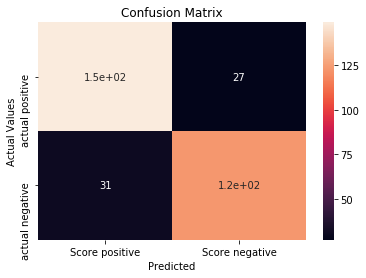

In [253]:
conf_mat = confusion_matrix(y_test,y_pred)
ax=plt.subplot()
# annot : write the data value in each cell.
# ax :  Axes in which to draw the plot
sns.heatmap(conf_mat,annot=True,ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(['Score positive','Score negative'])
ax.set_yticklabels(['actual positive','actual negative'])
